# PoseNet 2D to Kinect 2D

In [62]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='./mlflow-312506-6387830e8324.json'

In [63]:
import warnings
warnings.simplefilter('ignore')

In [64]:
random_state = 47
np.random.seed(random_state)

In [65]:
posenetDataPath = '../../datasets/posenet-uncut/'
kinectDataPath = '../../datasets/kinect_good_preprocessed_not_cut/'

X = None
y = None

train_test_ratio = 0.8

## 1. Data Preparation

### Load matching files from PoseNet and Kinect

In [66]:
import re

for file in os.listdir(posenetDataPath):
    if file.endswith('.csv'):
        try:
            posenetData = pd.read_csv(posenetDataPath + file)
            kinectData = pd.read_csv(kinectDataPath + '{}_kinect.csv'.format(file.replace('.csv', '')))
            # Check amount of frames
            if (len(posenetData) == len(kinectData)):
                posenetData.drop(columns=['FrameNo'], inplace=True)
                if X is None:
                    X = posenetData
                else:
                    X = pd.concat((X, posenetData), ignore_index=True)

                # Drop Z-columns from Kinect
                z = []
                for c in kinectData.columns:
                    if re.search("^.*_z$", c):
                        z.append(c)
                kinectData.drop(columns=z, inplace=True)
                kinectData.drop(columns=['FrameNo'], inplace=True)
                if y is None:
                    y = kinectData
                else:
                    y = pd.concat((y, kinectData), ignore_index=True)
        except IOError as e:
            print('Error in reading file: ', e)
            logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e)

print(X.shape)
print(y.shape)

(30502, 26)
(30502, 26)


### Training and test split

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=train_test_ratio, random_state=random_state)

input_dim = X_train.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24401, 26)
(24401, 26)
(6101, 26)
(6101, 26)


### Scaling

In [68]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

## 2. DL Model

### Early Stopping

In [69]:
from keras.callbacks import EarlyStopping

# Early stopping parameters
monitor = 'val_loss'
verbose = 1
patience = 20
mode = 'min'
restore_best_weights = True

early_stopping = EarlyStopping(
    monitor=monitor, 
    verbose=verbose,
    patience=patience,
    mode=mode,
    restore_best_weights=restore_best_weights)

### Layer Factory

In [70]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        if not activation:
            return Dropout(units=nodes)
        else:
            return Dropout(units=nodes, activation=activation)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

### Model Architecture

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

def create_model(optimizer):
    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    for layer in layers:
        model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(model.summary())
    return model

## 3. Evaluation metrics

In [72]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

## 4. MLFlow Experimentation

In [73]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "leftShoulder_x"),
    ColSpec("double", "leftShoulder_y"),
    ColSpec("double", "leftElbow_x"),
    ColSpec("double", "leftElbow_y"),
    ColSpec("double", "rightShoulder_x"),
    ColSpec("double", "rightShoulder_y"),
    ColSpec("double", "rightElbow_x"),
    ColSpec("double", "rightElbow_y"),
    ColSpec("double", "leftHand_x"),
    ColSpec("double", "leftHand_y"),
    ColSpec("double", "rightHand_x"),
    ColSpec("double", "rightHand_y"),
    ColSpec("double", "leftHip_x"),
    ColSpec("double", "leftHip_y"),
    ColSpec("double", "rightHip_x"),
    ColSpec("double", "rightHip_y"),
    ColSpec("double", "leftKnee_x"),
    ColSpec("double", "leftKnee_y"),
    ColSpec("double", "rightKnee_x"),
    ColSpec("double", "rightKnee_y"),
    ColSpec("double", "leftFoot_x"),
    ColSpec("double", "leftFoot_y"),
    ColSpec("double", "rightFoot_x"),
    ColSpec("double", "rightFoot_y"),
])
output_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [74]:
with mlflow.start_run() as run:
    # Model parameters
    units = 26
    activation = 'sigmoid'
    learning_rate = 0.001
    optimizer = 'RMSprop'
    loss = 'mse'
    metrics = ['mae']
    epochs = 500
    batch_size = 75
    layers = [ 
        { 'type': 'Dense', 'nodes':units, 'activation': activation },
        { 'type': 'Dense', 'nodes':units, 'activation': activation },
        { 'type': 'Dense', 'nodes':26, 'activation': ''}
    ]

    model = create_model(optimizer=optimizer)
    history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

    predictions = model.predict(X_test, verbose=1)
    # Invert transform on predictions
    predictions = y_scaler.inverse_transform(predictions)
    (mse, msa, r2, variance) = eval_metrics(y_test, predictions)

    # Print metrics
    print("\PoseNet_to_Kinect2D model (optimizer={}, learning_rate={}):".format(optimizer, learning_rate))
    print('MSE: ', mse)
    print('MSA: ', msa)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)

    # Log parameter, metrics, and model to MLflow
    mlflow.log_param("units", units)
    mlflow.log_param("activation", activation)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("batch size", batch_size)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("msa", msa)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("variance", variance)

    mlflow.keras.log_model(model, "PoseNet_to_Kinect2D", signature=signature)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 26)                702       
_________________________________________________________________
dense_13 (Dense)             (None, 26)                702       
_________________________________________________________________
dense_14 (Dense)             (None, 26)                702       
Total params: 2,106
Trainable params: 2,106
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
261/261 [==============================] - 1s 1ms/step - loss: 0.9789 - mae: 0.6945 - val_loss: 0.5888 - val_mae: 0.5000
Epoch 2/500
261/261 [==============================] - 0s 741us/step - loss: 0.5988 - mae: 0.4902 - val_loss: 0.4708 - val_mae: 0.4531
Epoch 3/500
261/261 [==============================] - 0s 708us/step - loss: 0.4675 - mae: 0.4429 - val_loss:

In [75]:
training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['mae']))

### Plot training and validation MAE & loss per epoch

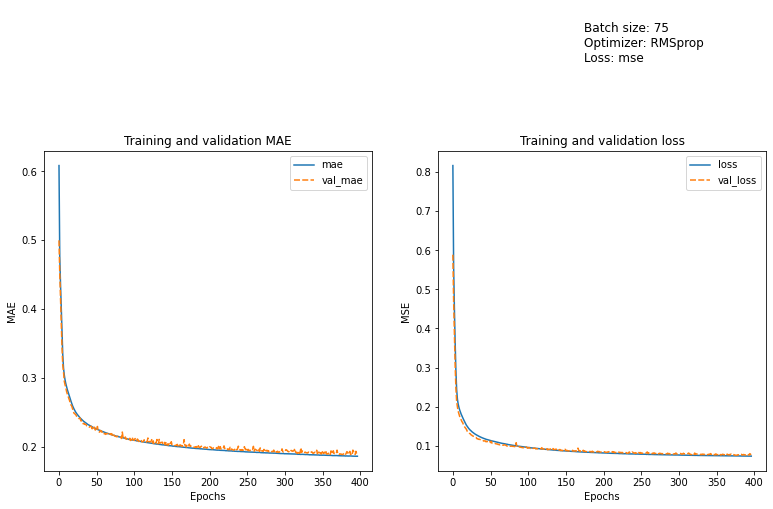

In [76]:
plots = [
           {'cols':['mae', 'val_mae'], 'title':'Training and validation MAE', 'yLabel':'MAE'},
           {'cols':['loss', 'val_loss'], 'title':'Training and validation loss', 'yLabel':'MSE'},
]

fig = plt.figure(figsize=(20,20))
fig_no = 331
title = '\nBatch size: {}\nOptimizer: {}\nLoss: {}'.format(batch_size,optimizer, loss)
fig.suptitle(title, fontsize="large", horizontalalignment='left', verticalalignment='top')

for i in range(len(plots)):
    ax = fig.add_subplot(str(fig_no))
    sns.lineplot(data=training_history[plots[i]['cols']], ax=ax)
    plt.title(plots[i]['title'])
    plt.xlabel('Epochs')
    plt.ylabel(plots[i]['yLabel'])
    fig_no += 1

plt.show()

## 5. Register Model

In [77]:
# model_uri = "runs:/{}/PoseNet_to_Kinect2D".format(run.info.run_id)
# mv = mlflow.register_model(model_uri, "PoseNet_to_Kinect2D")
# print("Name: {}".format(mv.name))
# print("Version: {}".format(mv.version))